# iSLAT Animated Plots — Parameter Evolution Visualizations

This notebook demonstrates how to create **animated plots** that show how molecular spectra evolve as physical parameters change. Animations are powerful for:
- Exploring parameter space interactively
- Creating figures for presentations and videos
- Understanding how temperature, column density, or other parameters affect spectral features

All animations use `matplotlib.animation.FuncAnimation` and can be saved as GIF or MP4 files.

## What This Notebook Covers:
1. **Setup** — Imports, paths, and molecule initialization
2. **Temperature Evolution** — Animate spectral changes from 300K to 1200K
3. **Column Density Evolution** — Watch optical depth effects as N_mol increases
4. **Radial Velocity Shift** — Animate Doppler shifts with color-coded velocity
5. **Multi-Molecule Animation** — Blend multiple species and show contributions
6. **Saving Animations** — Export to GIF and MP4 formats

In [1]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent.parent  # Plotting -> Notebooks -> Examples -> iSLAT
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Use the notebook backend for interactive plots
%matplotlib widget

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeLineList, Intensity, Spectrum

print("Imports successful!")

Imports successful!


In [2]:
# Define paths to HITRAN parameter files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"

water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")
hcn_par_file   = str(data_dir / "data_Hitran_HCN.par")

print("Data paths configured.")

Data paths configured.


## 1. Temperature Evolution Animation

Create an animation showing how the H2O spectrum changes as temperature increases from 300K to 1200K. Higher temperatures:
- Populate higher rotational states
- Shift emission to shorter wavelengths
- Broaden lines thermally

In [3]:
# Create a base molecule for temperature animation
h2o = Molecule(
    name="H2O",
    filepath=water_par_file,
    temp=850.0,
    n_mol=1e18,
    radius=0.5,
    distance=160.0,
    wavelength_range=(14.5, 17.5),
    fwhm=130.0,
    broad=1.0
)

In [4]:
# Pre-compute spectra for different temperatures
temperatures = np.linspace(300, 1200, 30)  # 30 frames from 300K to 1200K
spectra_data = []

print("Pre-computing spectra for temperature animation...")
for i, temp in enumerate(temperatures):
    h2o.temp = temp
    wavelengths, flux = h2o.get_flux(return_wavelengths=True)
    spectra_data.append((wavelengths.copy(), flux.copy()))
    if (i + 1) % 10 == 0:
        print(f"  Computed {i + 1}/{len(temperatures)} spectra")

# Find global flux range for consistent y-axis
all_fluxes = np.concatenate([s[1] for s in spectra_data])
flux_max = np.nanmax(all_fluxes) * 1.1

print(f"Done! Max flux: {flux_max:.2e} Jy")

Pre-computing spectra for temperature animation...
Calculating intensity for H2O: T=300.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=331.0344827586207K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=331.0344827586207K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=362.0689655172414K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=362.0689655172414K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=393.1034482758621K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=393.1034482758621K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=424.1379310344828K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=424.1379310344828K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=455.1724137931035K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=455.1724137931035K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=486.2068965517241K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=486.206896551724

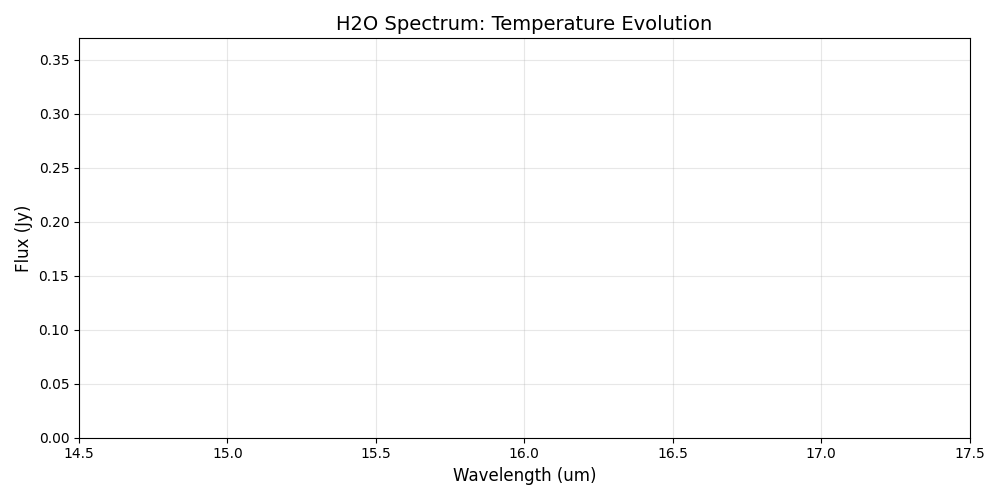

In [5]:
# Create the temperature evolution animation
fig, ax = plt.subplots(figsize=(10, 5))

# Initialize empty line
line, = ax.plot([], [], 'b-', lw=0.8)
temp_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=14,
                    fontweight='bold', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Set up the axes
ax.set_xlim(14.5, 17.5)
ax.set_ylim(0, flux_max)
ax.set_xlabel('Wavelength (um)', fontsize=12)
ax.set_ylabel('Flux (Jy)', fontsize=12)
ax.set_title('H2O Spectrum: Temperature Evolution', fontsize=14)
ax.grid(True, alpha=0.3)

def init():
    """Initialize animation."""
    line.set_data([], [])
    temp_text.set_text('')
    return line, temp_text

def animate(frame):
    """Update animation for each frame."""
    wavelengths, flux = spectra_data[frame]
    line.set_data(wavelengths, flux)
    temp_text.set_text(f'T = {temperatures[frame]:.0f} K')
    return line, temp_text

# Create animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(temperatures), interval=150, blit=True)

plt.tight_layout()
plt.show()

## 2. Column Density Evolution

Animate how line profiles change as column density increases. Watch the transition from optically thin (linear growth) to optically thick (saturation) regime.

In [6]:
# Pre-compute spectra for different column densities
# Use logarithmic spacing to cover several orders of magnitude
n_mol_values = np.logspace(16, 20, 25)  # 10^16 to 10^20 cm^-2

# Reset temperature
h2o.temp = 600.0

n_mol_spectra = []
print("Pre-computing spectra for column density animation...")
for i, n_mol in enumerate(n_mol_values):
    h2o.n_mol = n_mol
    wavelengths, flux = h2o.get_flux(return_wavelengths=True)
    n_mol_spectra.append((wavelengths.copy(), flux.copy()))
    if (i + 1) % 10 == 0:
        print(f"  Computed {i + 1}/{len(n_mol_values)} spectra")

# Find global flux range
all_n_fluxes = np.concatenate([s[1] for s in n_mol_spectra])
n_flux_max = np.nanmax(all_n_fluxes) * 1.1

print(f"Done! Max flux: {n_flux_max:.2e} Jy")

Pre-computing spectra for column density animation...
Calculating intensity for H2O: T=600.0K, N_mol=1.00e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.47e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.47e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=2.15e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=2.15e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=3.16e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=3.16e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=4.64e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=4.64e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=6.81e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=6.81e+16, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.47e+17, dv=1.0
Calculating intensity for H2O: T=600.0K, N_mol=1.4

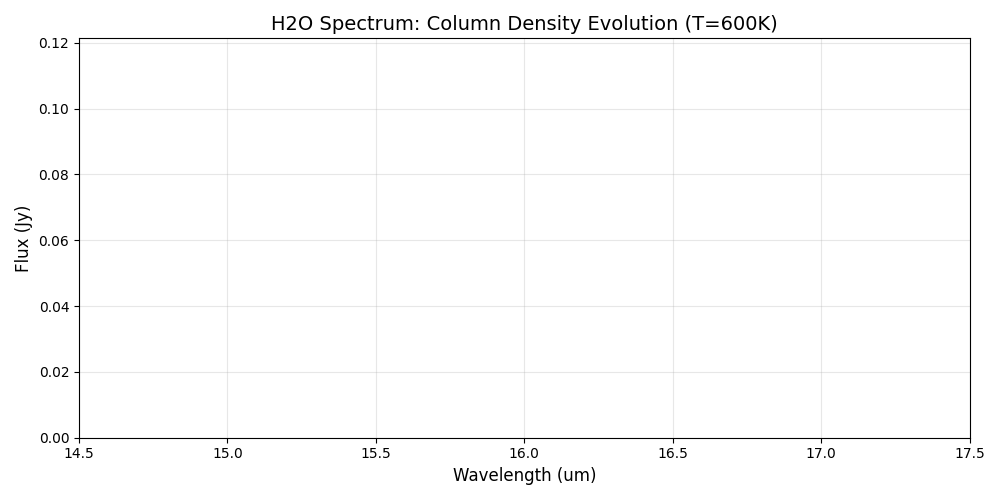

In [7]:
# Create the column density evolution animation
fig2, ax2 = plt.subplots(figsize=(10, 5))

# Initialize empty line
line2, = ax2.plot([], [], 'b-', lw=0.8)
nmol_text = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, fontsize=14,
                     fontweight='bold', verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Set up the axes
ax2.set_xlim(14.5, 17.5)
ax2.set_ylim(0, n_flux_max)
ax2.set_xlabel('Wavelength (um)', fontsize=12)
ax2.set_ylabel('Flux (Jy)', fontsize=12)
ax2.set_title('H2O Spectrum: Column Density Evolution (T=600K)', fontsize=14)
ax2.grid(True, alpha=0.3)

def init2():
    """Initialize animation."""
    line2.set_data([], [])
    nmol_text.set_text('')
    return line2, nmol_text

def animate2(frame):
    """Update animation for each frame."""
    wavelengths, flux = n_mol_spectra[frame]
    line2.set_data(wavelengths, flux)
    nmol_text.set_text(f'N = {n_mol_values[frame]:.1e} cm$^{{-2}}$')
    return line2, nmol_text

# Create animation
anim2 = FuncAnimation(fig2, animate2, init_func=init2,
                      frames=len(n_mol_values), interval=200, blit=True)

plt.tight_layout()
plt.show()

## 4. Radial Velocity Shift Animation

Animate spectral lines shifting due to radial velocity changes — useful for visualizing Doppler effects from disk rotation or stellar winds.

In [8]:
# Create a molecule with a narrow wavelength window to see RV shifts clearly
h2o_rv = Molecule(
    name="H2O",
    filepath=water_par_file,
    temp=850.0,
    n_mol=1e18,
    radius=1.0,
    distance=140.0,
    wavelength_range=(15.8, 16.2),
    fwhm=130.0,
    broad=1.0,
    rv_shift=0.0
)

# Generate spectra for different RV shifts (simulate rotation)
rv_values = np.linspace(-200, 200, 40)  # -30 to +30 km/s
rv_spectra = []

print("Computing spectra for RV shift animation...")
for rv in rv_values:
    h2o_rv.rv_shift = rv
    wl, fl = h2o_rv.get_flux(return_wavelengths=True)
    rv_spectra.append((wl.copy(), fl.copy()))

rv_wavelengths = rv_spectra[0][0]
rv_flux_max = max(np.nanmax(s[1]) for s in rv_spectra) * 1.1

print(f"Done! Generated {len(rv_values)} spectra.")

Computing spectra for RV shift animation...
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Applying RV shift of -200.0 km/s for molecule H2O
Applying RV shift of -189.74358974358975 km/s for molecule H2O
Applying RV shift of -179.48717948717947 km/s for molecule H2O
Applying RV shift of -169.23076923076923 km/s for molecule H2O
Applying RV shift of -158.97435897435898 km/s for molecule H2O
Applying RV shift of -148.71794871794873 km/s for molecule H2O
Applying RV shift of -138.46153846153845 km/s for molecule H2O
Applying RV shift of -128.2051282051282 km/s for molecule H2O
Applying RV shift of -117.94871794871794 km/s for molecule H2O
Applying RV shift of -107.69230769230768 km/s for molecule H2O
Applying RV shift of -97.43589743589743 km/s for molecule H2O
Applying RV shift of -87.17948717948717 km/s for molecule H2O
Applying RV shift of -76.9230769230769 km/s for molecule H2O
Applying RV shift of -66.66666666666666 km/s for molecule H2O
Applying RV shift of -56.4102

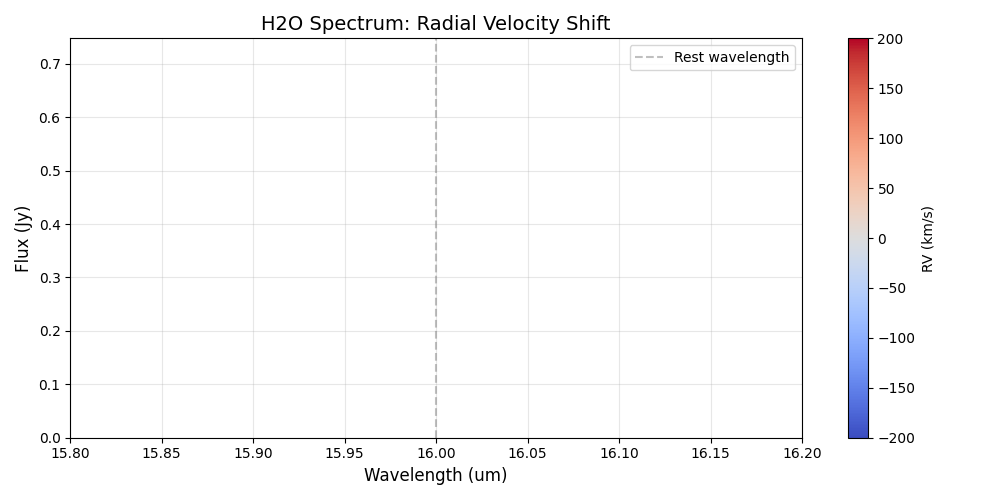

In [9]:
# Create RV shift animation
fig5, ax5 = plt.subplots(figsize=(10, 5))

# Use coolwarm colormap for blueshift/redshift
cmap_rv = plt.cm.coolwarm
norm_rv = plt.Normalize(vmin=rv_values.min(), vmax=rv_values.max())

line5, = ax5.plot([], [], lw=1.2)
rv_text = ax5.text(0.02, 0.95, '', transform=ax5.transAxes, fontsize=14,
                   fontweight='bold', verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add reference line for zero velocity
ax5.axvline(x=16.0, color='gray', linestyle='--', alpha=0.5, label='Rest wavelength')

ax5.set_xlim(15.8, 16.2)
ax5.set_ylim(0, rv_flux_max)
ax5.set_xlabel('Wavelength (um)', fontsize=12)
ax5.set_ylabel('Flux (Jy)', fontsize=12)
ax5.set_title('H2O Spectrum: Radial Velocity Shift', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend(loc='upper right')

# Add colorbar for RV
sm_rv = plt.cm.ScalarMappable(cmap=cmap_rv, norm=norm_rv)
sm_rv.set_array([])
cbar_rv = plt.colorbar(sm_rv, ax=ax5, label='RV (km/s)')

def init5():
    line5.set_data([], [])
    rv_text.set_text('')
    return line5, rv_text

def animate5(frame):
    wl, fl = rv_spectra[frame]
    line5.set_data(wl, fl)
    line5.set_color(cmap_rv(norm_rv(rv_values[frame])))
    rv_text.set_text(f'RV = {rv_values[frame]:+.1f} km/s')
    return line5, rv_text

anim5 = FuncAnimation(fig5, animate5, init_func=init5,
                      frames=len(rv_values), interval=100, blit=True)

plt.tight_layout()
plt.show()

## 5. Combined Multi-Molecule Animation

Show multiple molecules evolving together, useful for understanding relative contributions to blended features.

In [10]:
# Create molecules for multi-species animation
wavelength_range = (13.5, 17.0)

mols = {
    'H2O': Molecule(
        name="H2O", filepath=water_par_file, temp=500.0, n_mol=1e18,
        radius=1.0, distance=140.0, wavelength_range=wavelength_range,
        fwhm=10.0, broad=2.0
    ),
    'CO2': Molecule(
        name="CO2", filepath=co2_par_file, temp=400.0, n_mol=5e17,
        radius=1.0, distance=140.0, wavelength_range=wavelength_range,
        fwhm=10.0, broad=2.0
    ),
    'HCN': Molecule(
        name="HCN", filepath=hcn_par_file, temp=600.0, n_mol=1e17,
        radius=0.8, distance=140.0, wavelength_range=wavelength_range,
        fwhm=10.0, broad=2.0
    )
}

colors = {'H2O': 'blue', 'CO2': 'red', 'HCN': 'green'}

# Generate spectra for temperature evolution of all molecules
temps_multi = np.linspace(300, 1000, 25)
multi_spectra = {name: [] for name in mols}

print("Computing multi-molecule spectra...")
for temp in temps_multi:
    for name, mol in mols.items():
        mol.temp = temp
        wl, fl = mol.get_flux(return_wavelengths=True)
        multi_spectra[name].append(fl.copy())

common_wl = wl.copy()

print(f"Done! Generated {len(temps_multi)} frames for {len(mols)} molecules.")

Computing multi-molecule spectra...
Calculating intensity for H2O: T=300.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=300.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for CO2: T=300.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for HCN: T=300.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for H2O: T=329.1666666666667K, N_mol=1.00e+18, dv=1.0
Calculating intensity for HCN: T=300.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for H2O: T=329.1666666666667K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=329.1666666666667K, N_mol=5.00e+17, dv=1.0
Calculating intensity for HCN: T=329.1666666666667K, N_mol=1.00e+17, dv=1.0
Calculating intensity for CO2: T=329.1666666666667K, N_mol=5.00e+17, dv=1.0
Calculating intensity for HCN: T=329.1666666666667K, N_mol=1.00e+17, dv=1.0
Calculating intensity for H2O: T=358.3333333333333K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=358.3333333333333K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=358

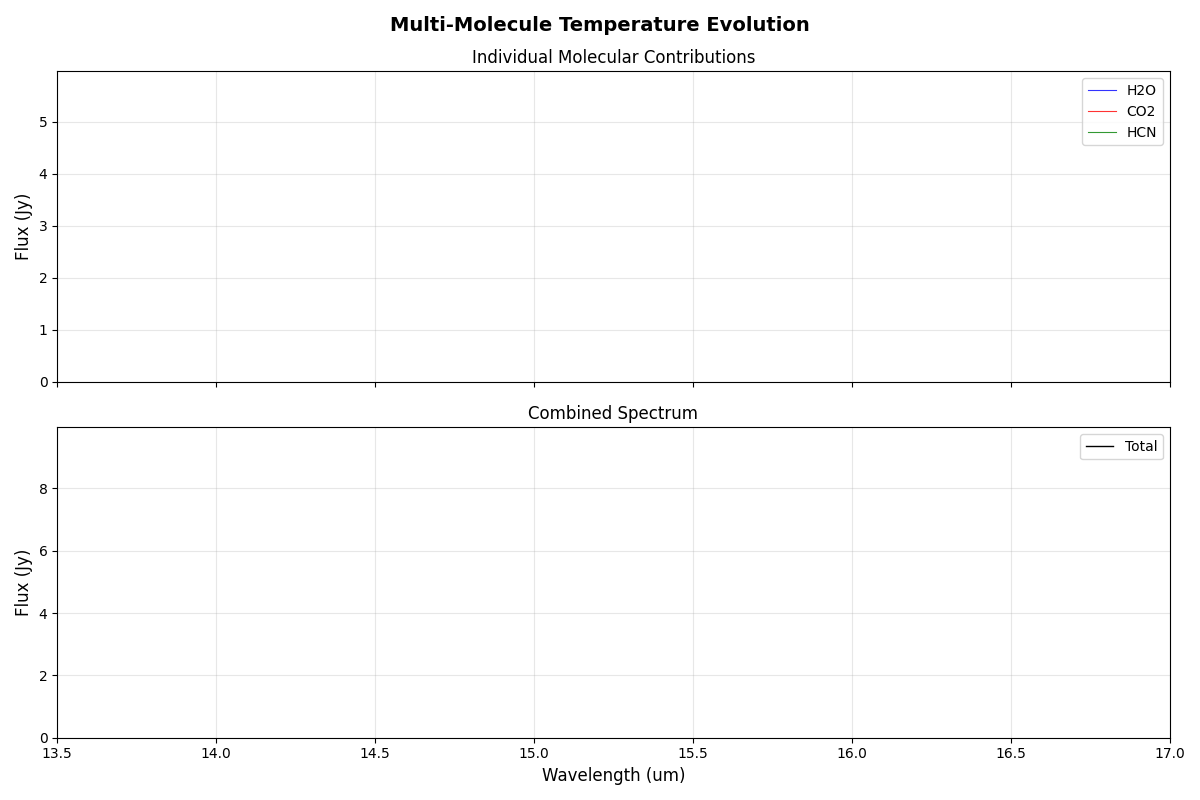

In [11]:
# Create multi-molecule animation
fig6, (ax6a, ax6b) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top panel: individual molecules
lines_dict = {}
for name, color in colors.items():
    line, = ax6a.plot([], [], color=color, lw=0.8, label=name, alpha=0.8)
    lines_dict[name] = line

# Bottom panel: total flux
line_total, = ax6b.plot([], [], 'k-', lw=1.0, label='Total')

temp_text6 = ax6a.text(0.02, 0.95, '', transform=ax6a.transAxes, fontsize=14,
                       fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Find max flux across all
all_multi_flux = []
for i in range(len(temps_multi)):
    total = sum(multi_spectra[name][i] for name in mols)
    all_multi_flux.extend(total)
flux_max_multi = max(all_multi_flux) * 1.1

# Configure axes
ax6a.set_xlim(13.5, 17.0)
ax6a.set_ylim(0, flux_max_multi * 0.6)
ax6a.set_ylabel('Flux (Jy)', fontsize=12)
ax6a.set_title('Individual Molecular Contributions', fontsize=12)
ax6a.legend(loc='upper right')
ax6a.grid(True, alpha=0.3)

ax6b.set_xlim(13.5, 17.0)
ax6b.set_ylim(0, flux_max_multi)
ax6b.set_xlabel('Wavelength (um)', fontsize=12)
ax6b.set_ylabel('Flux (Jy)', fontsize=12)
ax6b.set_title('Combined Spectrum', fontsize=12)
ax6b.legend(loc='upper right')
ax6b.grid(True, alpha=0.3)

fig6.suptitle('Multi-Molecule Temperature Evolution', fontsize=14, fontweight='bold')

def init6():
    for line in lines_dict.values():
        line.set_data([], [])
    line_total.set_data([], [])
    temp_text6.set_text('')
    return list(lines_dict.values()) + [line_total, temp_text6]

def animate6(frame):
    total_flux = np.zeros_like(common_wl)
    for name in mols:
        flux = multi_spectra[name][frame]
        lines_dict[name].set_data(common_wl, flux)
        total_flux += flux
    line_total.set_data(common_wl, total_flux)
    temp_text6.set_text(f'T = {temps_multi[frame]:.0f} K')
    return list(lines_dict.values()) + [line_total, temp_text6]

anim6 = FuncAnimation(fig6, animate6, init_func=init6,
                      frames=len(temps_multi), interval=150, blit=True)

plt.tight_layout()
plt.show()

## 6. Saving Animations

Export animations to GIF or MP4 for presentations and publications.

**Note**: Saving to MP4 requires `ffmpeg` to be installed. GIF export works with the default `pillow` writer.

In [12]:
# Define output directory for animations
#output_dir = Path(islat_root) / "Examples" / "Notebooks" / "Plotting" / "animations"
#output_dir.mkdir(exist_ok=True)

In [13]:
# Save temperature animation as GIF
# Uncomment the following lines to save:

# gif_path = output_dir / "h2o_temperature_evolution.gif"
# anim.save(str(gif_path), writer='pillow', fps=10)
# print(f"Saved GIF: {gif_path}")

print("To save animations, uncomment the save commands above.")
print("For MP4 output, ensure ffmpeg is installed.")

To save animations, uncomment the save commands above.
For MP4 output, ensure ffmpeg is installed.


In [14]:
# Example: Save as MP4 (requires ffmpeg)
# Uncomment to save:

# from matplotlib.animation import FFMpegWriter
# mp4_path = output_dir / "co_temperature_evolution.mp4"
# writer = FFMpegWriter(fps=15, metadata=dict(artist='iSLAT'), bitrate=1800)
# anim4.save(str(mp4_path), writer=writer)
# print(f"Saved MP4: {mp4_path}")

print("MP4 saving example shown above (uncomment to use).")

MP4 saving example shown above (uncomment to use).


## Summary

This notebook demonstrated several animation techniques for visualizing molecular parameter evolution:

| Section | Animation Type | Key Concept |
|---------|---------------|-------------|
| 1 | Temperature Evolution | Excitation effects on line intensities |
| 2 | Column Density Evolution | Optical depth saturation transitions |
| 4 | RV Shift with Colormap | Doppler shifts with color-coded velocity |
| 5 | Multi-Molecule | Species blending and relative contributions |
| 6 | Saving Animations | GIF and MP4 export workflows |

**Key matplotlib.animation functions used:**
- `FuncAnimation(fig, update_func, frames, interval, blit)` — Core animation class
- `blit=True` — Efficient partial redrawing
- `anim.save(path, writer)` — Export to GIF (PillowWriter) or MP4 (FFMpegWriter)